In [77]:
#import relevant modules
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn
import imblearn
import sys

import tensorflow as tf
import keras.backend as K
from keras.models import Model, Sequential
from keras.utils import plot_model
from keras.layers import Input, Dense, Embedding, SpatialDropout1D, concatenate, BatchNormalization
from keras.layers import GRU, LSTM, Bidirectional, GlobalAveragePooling1D, GlobalMaxPooling1D, Conv1D
from keras.preprocessing import text, sequence
from keras.callbacks import Callback

#Ignore Warnings
import warnings
warnings.filterwarnings('ignore')

#settings
pd.set_option('display.max_columns', None)
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(precision=3)
sns.set(style="darkgrid")
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [92]:
#Loading Data
train = pd.read_csv("network-intrusion-detection/Train_data.csv")
test = pd.read_csv("network-intrusion-detection/Test_data.csv")

In [93]:
train.head(4)

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,class
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,2,0.0,0.0,0.0,0.0,1.00,0.00,0.0,150,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13,1,0.0,0.0,0.0,0.0,0.08,0.15,0.0,255,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,6,1.0,1.0,0.0,0.0,0.05,0.07,0.0,255,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,anomaly
3,0,tcp,http,SF,232,8153,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,5,5,0.2,0.2,0.0,0.0,1.00,0.00,0.0,30,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal


In [94]:
print("Training Data has {} rows & {} Columns".format(train.shape[0],train.shape[1]))

Training Data has 25192 rows & 42 Columns


In [95]:
train.isnull().any().sum()
test.isnull().any().sum()

0

In [96]:
#descriptive statistics
train.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
count,25192.000000,2.519200e+04,2.519200e+04,25192.000000,25192.000000,25192.00000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.0,25192.0,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000,25192.000000
mean,305.054104,2.433063e+04,3.491847e+03,0.000079,0.023738,0.00004,0.198039,0.001191,0.394768,0.227850,0.001548,0.001350,0.249841,0.014727,0.000357,0.004327,0.0,0.0,0.009130,84.591180,27.698754,0.286338,0.283762,0.118630,0.120260,0.660559,0.062363,0.095931,182.532074,115.063036,0.519791,0.082539,0.147453,0.031844,0.285800,0.279846,0.117800,0.118769
std,2686.555640,2.410805e+06,8.883072e+04,0.008910,0.260221,0.00630,2.154202,0.045418,0.488811,10.417352,0.039316,0.048785,11.500842,0.529602,0.018898,0.098524,0.0,0.0,0.095115,114.673451,72.468242,0.447312,0.447599,0.318745,0.322335,0.439637,0.178550,0.256583,98.993895,110.646850,0.448944,0.187191,0.308367,0.110575,0.445316,0.446075,0.305869,0.317333
min,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.090000,0.000000,0.000000,84.000000,10.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,4.400000e+01,0.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,14.000000,8.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,255.000000,61.000000,0.510000,0.030000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,2.790000e+02,5.302500e+02,0.000000,0.000000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,144.000000,18.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.060000,0.000000,255.000000,255.000000,1.000000,0.070000,0.060000,0.020000,1.000000,1.000000,0.000000,0.000000
max,42862.000000,3.817091e+08,5.151385e+06,1.000000,3.000000,1.00000,77.000000,4.000000,1.000000,884.000000,1.000000,2.000000,975.000000,40.000000,1.000000,8.000000,0.0,0.0,1.000000,511.000000,511.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,255.000000,255.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [97]:
print(train['num_outbound_cmds'].value_counts())
print(test['num_outbound_cmds'].value_counts())

0    25192
Name: num_outbound_cmds, dtype: int64
0    22544
Name: num_outbound_cmds, dtype: int64


In [98]:
#'num_outbound_cmds' is a redundant column so remove it from both train and test datasets
train.drop(['num_outbound_cmds'],axis=1,inplace=True)
test.drop(['num_outbound_cmds'],axis=1,inplace=True)

In [120]:
#Attack class Distribution
train['class'].value_counts()


normal     13449
anomaly    11743
Name: class, dtype: int64

In [101]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# extract numerical attributes and scale it to have zero mean and unit variance  
cols = train.select_dtypes(include=['float64','int64']).columns
sc_train = scaler.fit_transform(train.select_dtypes(include=['float64','int64']))
sc_test = scaler.fit_transform(test.select_dtypes(include=['float64','int64']))

# turn the result back to a dataframe
sc_traindf = pd.DataFrame(sc_train, columns = cols)
sc_testdf = pd.DataFrame(sc_test, columns = cols)

In [102]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
# extract categorical attributes from both training and test sets 
cattrain = train.select_dtypes(include=['object']).copy()
cattest = test.select_dtypes(include=['object']).copy()

# encode the categorical attributes
traincat = cattrain.apply(encoder.fit_transform)
testcat = cattest.apply(encoder.fit_transform)

# separate target column from encoded data 
enctrain = traincat.drop(['class'], axis=1)
cat_Ytrain = traincat[['class']].copy()

In [106]:
train_x = pd.concat([sc_traindf,enctrain],axis=1)
train_y = train['class']
train_x.shape

(25192, 40)

In [107]:
test_df = pd.concat([sc_testdf,testcat],axis=1)
test_df.shape

(22544, 40)

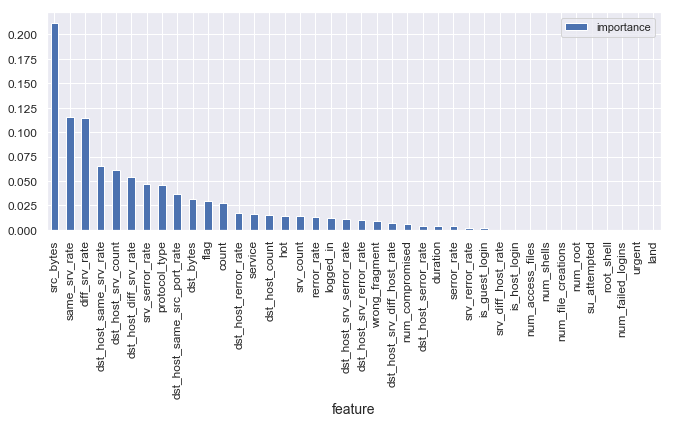

In [108]:
#feature Selection
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier();

# fit random forest classifier on the training set
rfc.fit(train_x, train_y);
# extract important features
score = np.round(rfc.feature_importances_,3)
importances = pd.DataFrame({'feature':train_x.columns,'importance':score})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
# plot importances
plt.rcParams['figure.figsize'] = (11, 4)
importances.plot.bar();

In [109]:
from sklearn.feature_selection import RFE
import itertools
rfc = RandomForestClassifier()

# create the RFE model and select 10 attributes
rfe = RFE(rfc, n_features_to_select=15)
rfe = rfe.fit(train_x, train_y)

# summarize the selection of the attributes
feature_map = [(i, v) for i, v in itertools.izip_longest(rfe.get_support(), train_x.columns)]
selected_features = [v for i, v in feature_map if i==True]

selected_features

['src_bytes',
 'dst_bytes',
 'hot',
 'logged_in',
 'count',
 'srv_count',
 'same_srv_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'protocol_type',
 'service',
 'flag']

In [133]:
#dataset partition
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(train_x,train_y,train_size=0.70, random_state=2)
print(len(X_train),len(X_test),len(Y_train),len(Y_test))

(17634, 7558, 17634, 7558)


In [111]:
#fitting models
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

#Train KNeighborsClassifier Model
KNN_Classifier = KNeighborsClassifier(n_jobs=-1)
KNN_Classifier.fit(X_train, Y_train);

#Train LogisticRegression Model
LGR_Classifier = LogisticRegression(n_jobs=-1, random_state=0)
LGR_Classifier.fit(X_train, Y_train);

#Train Gaussian Navie Bayes Model
BNB_Classifier = BernoulliNB()
BNB_Classifier.fit(X_train,Y_train);

#Train Decision Tree Model
DTC_Classifier = tree.DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
DTC_Classifier.fit(X_train, Y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=0,
            splitter='best')

In [112]:
#evaluation
from sklearn import metrics

models=[]
models.append(('Naive Bayes Classifier', BNB_Classifier))
models.append(('Decision Tree Classifier', DTC_Classifier))
models.append(('KNeighborsClassifier', KNN_Classifier))
models.append(('LogisticRegression', LGR_Classifier))
acc = []
cross_score = []

for i,v in models:
    scores = cross_val_score(v,X_train, Y_train, cv=10)
    accuracy = metrics.accuracy_score(Y_train,v.predict(X_train))
    confusion_matrix = metrics.confusion_matrix(Y_train,v.predict(X_train))
    classification = metrics.classification_report(Y_train,v.predict(X_train))
    print('==========================={} Model Evaluation==============================='.format(i))
    print("Cross Validation Mean Score:", scores.mean())
    print("Model Accuracy:", accuracy)
    print("confusion matrix")
    print(confusion_matrix)
    print("Classification Report")
    print(classification)
    acc.append(accuracy)
    cross_score.append(scores.mean())
    
print(cross_score)

===========================Naive Bayes Classifier Model Evaluation===============================
('Cross Validation Mean Score:', 0.9071664846399194)
('Model Accuracy:', 0.9071679709651809)
confusion matrix
[[7000 1245]
 [ 392 8997]]
Classification Report
              precision    recall  f1-score   support

     anomaly       0.95      0.85      0.90      8245
      normal       0.88      0.96      0.92      9389

   micro avg       0.91      0.91      0.91     17634
   macro avg       0.91      0.90      0.91     17634
weighted avg       0.91      0.91      0.91     17634

===========================Decision Tree Classifier Model Evaluation===============================
('Cross Validation Mean Score:', 0.9960867629468831)
('Model Accuracy:', 1.0)
confusion matrix
[[8245    0]
 [   0 9389]]
Classification Report
              precision    recall  f1-score   support

     anomaly       1.00      1.00      1.00      8245
      normal       1.00      1.00      1.00      9389

   micro

('Accuracy is :', [0.9071679709651809, 1.0, 0.9937620505840989, 0.9546898037881365])
('cross validation score:', [0.9071664846399194, 0.9960867629468831, 0.9914372077623872, 0.9538961919964779])


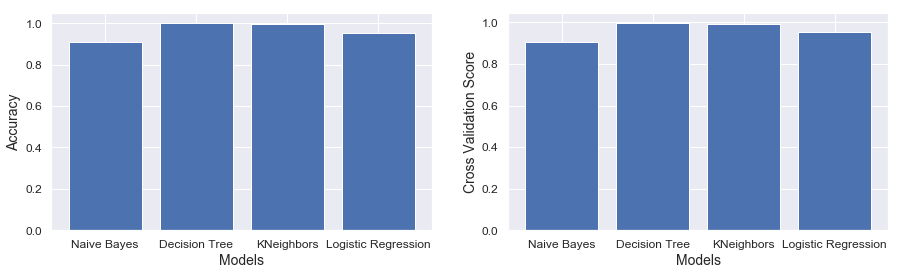

In [113]:
plt.figure(figsize=[15,4])
print("Accuracy is :", acc)
print("cross validation score:", cross_score)
plt.subplot(121)
models = ['Naive Bayes','Decision Tree', 'KNeighbors', 'Logistic Regression']
plt.bar(models,acc)
plt.xlabel("Models")
plt.ylabel("Accuracy")

plt.subplot(122)
models = ['Naive Bayes','Decision Tree', 'KNeighbors', 'Logistic Regression']
plt.bar(models,cross_score)
plt.xlabel("Models")
plt.ylabel("Cross Validation Score")


plt.show()

In [114]:
#deep neural network classifier
def getdnnclf():
    clf = Sequential()
    clf.add(Dense(1024, input_dim = 40, activation = 'relu'))
    clf.add(BatchNormalization())
    clf.add(Dense(1024, activation='relu'))
    clf.add(BatchNormalization())
    clf.add(Dense(512, activation='relu'))
    clf.add(Dense(64, activation='relu'))
    clf.add(Dense(1, activation='sigmoid'))
    clf.compile(loss='binary_crossentropy', optimizer='adam', metrics = ['accuracy'])
    return clf

In [126]:

attack_classes = ['back', 'buffer_overflow', 'ftp_write', 'guess_passwd', 'imap', 'ipsweep', 'land', 
                  'loadmodule', 'multihop', 'neptune', 'nmap', 'normal', 'perl', 'phf', 'pod', 'portsweep',
                  'rootkit', 'satan', 'smurf', 'spy', 'teardrop', 'warezclient', 'warezmaster']

train_label = pd.DataFrame()
test_label = pd.DataFrame()

for attack_type in attack_classes:
    train_label[attack_type] = train['service'].apply(lambda x : int(x == attack_type))
    test_label[attack_type] = test['service'].apply(lambda x : int(x == attack_type))


In [127]:

stacked_train_df = {}
stacked_test_df = {}

for attack_type in attack_classes:
    stacked_train_df[attack_type] = pd.DataFrame()
    stacked_test_df[attack_type] = pd.DataFrame()

In [137]:
# training on DNN classifier

'''dnn_accuracy = []
    
for attack_type in attack_classes:
    clf = getdnnclf()
    clf.fit(X_train, train_label[attack_type], batch_size = 1024, epochs = 5, 
            validation_data = (Y_train, test_label[attack_type]), verbose = 0)
    #clf.fit(X_train,Y_train,epochs=5,batch_size = 1024)
    y_pred = (clf.predict(X_test) >= 0.5).astype(int)
    stacked_train_df[attack_type]['dnn'] = (clf.predict(X_train) >= 0.5).astype(int)
    stacked_test_df[attack_type]['dnn'] = y_pred
    dnn_accuracy += [accuracy_score(test_label[attack_type], y_pred)]
    
mean_dnn_accuracy = np.mean(dnn_accuracy)
    
print("Deep Neural Network Classifier...")
print("Mean Accuracy score : " + str(mean_dnn_accuracy))
#score = model.evaluate(X_test, Y_test, batch_size=128)

#score'''
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y1_train=lb.fit_transform(Y_train)
Y1_test=lb.fit_transform(Y_test)
clf = getdnnclf()
clf.fit(X_train,Y1_train,epochs=5,batch_size=1024)
score = clf.evaluate(X_test, Y1_test, batch_size=128)

score



Epoch 1/5
17634/17634 [==============================] - 5s 293us/step - loss: 0.1781 - acc: 0.9173
Epoch 2/5
17634/17634 [==============================] - 3s 148us/step - loss: 0.0532 - acc: 0.9814
Epoch 3/5
17634/17634 [==============================] - 3s 150us/step - loss: 0.0313 - acc: 0.9883
Epoch 4/5
17634/17634 [==============================] - 3s 152us/step - loss: 0.0286 - acc: 0.9893
Epoch 5/5
7558/7558 [==============================] - 2s 203us/step


[0.03552516650074078, 0.9921937020375761]